In [1]:
import requests
from dotenv import load_dotenv
import os
import json
import base64   
import pandas as pd
import librosa
import numpy as np
import lyricsgenius
import langdetect
import re
import string
import tempfile

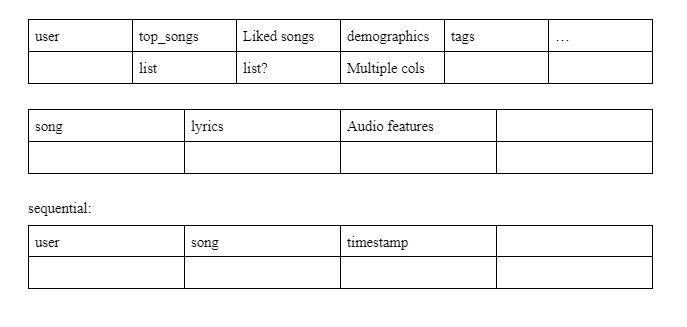

In [2]:
# For any api we can try using the "+" email trick to get more API keys

spotify_client_id = "dae4aecab9ff4dfeb227cb9ff279ebf3"
spotify_client_secret = "0120d846e45e44c4843a8f983eeeb4a2"

genius_client_id = "wZZ2RWc5mqp-5Pbz2W1rQJWE8LQ3pFBrb1Hw5_AOqgybq28mt7kjdjcG4zktCNbO"
genius_client_secret = "PefqBJHor_muDgTutGlaXXaxmzsI7TQCps9FQ3FwkUTT0WJIT3s0A5YA9mnFbfp_-CBhQF7b0omgE8kaM3dJ3w"
genius_access_token = "NUHHVpwnmbDYUYw8Padu0gQeHvYN4OsKYtE2MKNUpBUI6yR-xZXKY6S5NvCnFbiP"

lastfm_api_key = "97d5a64d5ba4a8bc580b752ceff3b87f"
lastfm_secret = "35175090bd61f6f16ac607bd26e5b1de"

aud_api = "d3e2b670a1feab78763ef53399364109" ## Valid until 4 march

Deezer API to get 30 seconds preview of songs

In [3]:
def search_deezer_track(track_name):
    search_url = "https://api.deezer.com/search/track"
    params = {"q": track_name}
    response = requests.get(search_url, params=params)
    
    if response.status_code == 200:
        tracks = response.json().get('data', [])
        for track in tracks:
            print(f"Track ID: {track['id']}, Title: {track['title']}, Artist: {track['artist']['name']}")
    else:
        print(f"Failed to search tracks. Status code: {response.status_code}")


def get_deezer_track_info(track_id):
    """
    Fetch track information and MP3 preview file URL from Deezer API.

    Parameters:
    - track_id: The unique identifier for the track on Deezer.

    Returns:
    A dictionary with track information and the preview URL.
    """
    base_url = "https://api.deezer.com/track/"
    response = requests.get(f"{base_url}{track_id}")
    
    if response.status_code == 200:
        data = response.json()
        main_artist = data.get("artist", {}).get("name", "")
        contributors = [contributor['name'] for contributor in data.get("contributors", []) if contributor['name'] != main_artist]
        featured_artists = ", ".join(contributors) if contributors else None

        track_info = {
            "title": data.get("title"),
            "artist": main_artist,
            "featured_artists": featured_artists,
            "duration": data.get("duration"),
            "album": data.get("album", {}).get("title"),
            "preview_url": data.get("preview"),
            "link": data.get("link")
        }
        return track_info
    else:
        print(f"Failed to fetch data for track ID {track_id}. Status code: {response.status_code}")
        return {}


def get_song_details_from_url(audio_url, api_token):
    """
    Fetch song details using AudD API from an audio URL.

    Parameters:
    - audio_url: URL to the audio file for song recognition.
    - api_token: Your AudD API token.

    Returns:
    A dictionary with song details.
    """
    api_endpoint = "https://api.audd.io/"
    params = {
        "url": audio_url,
        "return": "apple_music,spotify",  # You can specify what additional data you want (e.g., metadata from Apple Music or Spotify)
        "api_token": api_token,
    }

    response = requests.post(api_endpoint, data=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch song details. Status code: {response.status_code}")
        return {}



# audio_url = "https://cdns-preview-c.dzcdn.net/stream/c-cabe5eee524ba4c4708032cdc0bbe7fe-4.mp3"  # Replace with the actual URL to the audio file
# song_details = get_song_details_from_url(audio_url, aud_api)
# print(json.dumps(song_details, indent=4))

get_deezer_track_info("811112942")

{'title': 'Blueming',
 'artist': 'IU',
 'featured_artists': None,
 'duration': 217,
 'album': 'Love poem',
 'preview_url': 'https://cdns-preview-c.dzcdn.net/stream/c-cabe5eee524ba4c4708032cdc0bbe7fe-4.mp3',
 'link': 'https://www.deezer.com/track/811112942'}

LastFM API to get Song info

In [4]:
base_url = 'http://ws.audioscrobbler.com/2.0/'

def lastfm_get(payload):
    headers = {'user-agent': 'DataCollectorBot'}
    payload['api_key'] = lastfm_api_key
    payload['format'] = 'json'
    response = requests.get(base_url, headers=headers, params=payload)
    return response.json()

def get_song_details(artist_name, track_name):
    payload = {
        'method': 'track.getInfo',
        'artist': artist_name,
        'track': track_name,
    }
    json_response = lastfm_get(payload)
    return json_response.get('track', {})

def get_artist_details(artist_name):
    payload = {
        'method': 'artist.getInfo',
        'artist': artist_name,
    }
    json_response = lastfm_get(payload)
    return json_response.get('artist', {})

def get_recommendations(artist_name, track_name, limit=20):
    payload = {
        'method': 'track.getSimilar',
        'artist': artist_name,
        'track': track_name,
        'limit': limit,
    }
    json_response = lastfm_get(payload)
    return json_response.get('similartracks', {}).get('track', [])


LastFM API to get top / trending tracks (Global and by country)

In [5]:
def get_global_top_tracks(limit=50):
    payload = {
        'method': 'chart.getTopTracks',
        'limit': limit,
    }
    json_response = lastfm_get(payload)
    return json_response.get('tracks', {}).get('track', [])

def get_top_tracks_by_country(country, limit=50):
    payload = {
        'method': 'geo.getTopTracks',
        'country': country,
        'limit': limit,
    }
    json_response = lastfm_get(payload)
    return json_response.get('tracks', {}).get('track', [])

Spotify API

In [7]:
def get_token():
    auth_string = spotify_client_id + ":" + spotify_client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization" : "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url,headers=headers, data=data)
    json_result= json.loads(result.content)
    token = json_result['access_token']
    return token

def get_auth_header(token):
    return {"Authorization": "Bearer " + token }


def get_song_details(song_id, auth_header):
    """Fetch song metadata using Spotify API."""
    url = f"https://api.spotify.com/v1/tracks/{song_id}"
    response = requests.get(url, headers=auth_header)
    return response.json()

def get_audio_features(song_id, auth_header):
    """Fetch audio features for a song."""
    url = f"https://api.spotify.com/v1/audio-features/{song_id}"
    response = requests.get(url, headers=auth_header)
    return response.json()

def get_audio_analysis(song_id, auth_header):
    """Fetch detailed audio analysis for a song."""
    url = f"https://api.spotify.com/v1/audio-analysis/{song_id}"
    response = requests.get(url, headers=auth_header)
    return response.json()


def get_artist_details(artist_id, auth_header):
    """Fetch artist metadata including popularity."""
    url = f"https://api.spotify.com/v1/artists/{artist_id}"
    response = requests.get(url, headers=auth_header)
    return response.json()

def download_song_preview(preview_url, song_id):
    if not preview_url:
        print(f"No preview available for song ID {song_id}")
        return None
    response = requests.get(preview_url)
    if response.status_code == 200:
        file_path = f"previews/{song_id}.mp3"
        with open(file_path, 'wb') as file:
            file.write(response.content)
        return file_path
    else:
        print(f"Failed to download preview for song ID {song_id}")
        return None

## the seeds must be their ids
def get_recommendations(token, seed_artists=None, seed_genres=None, seed_tracks=None):
    url = "https://api.spotify.com/v1/recommendations"
    headers = get_auth_header(token)
    params = {
        "limit": 20  # You can adjust this to fetch more or fewer tracks
    }
    if seed_artists:
        params["seed_artists"] = ','.join(seed_artists)
    if seed_genres:
        params["seed_genres"] = ','.join(seed_genres)
    if seed_tracks:
        params["seed_tracks"] = ','.join(seed_tracks)
    
    result = requests.get(url, headers=headers, params=params)
    
    try:
        result.raise_for_status()
        json_result = result.json()
        return json_result['tracks']
    except json.JSONDecodeError:
        print(f"Error decoding JSON response: {result.content}")
        return None
    except requests.exceptions.HTTPError as err:
        print(f"HTTP error: {err}")
        return None


In [8]:
def get_spotify_token():
    auth_string = spotify_client_id + ":" + spotify_client_secret
    auth_bytes = auth_string.encode("utf-8")
    auth_base64 = str(base64.b64encode(auth_bytes), "utf-8")

    url = "https://accounts.spotify.com/api/token"
    headers = {
        "Authorization" : "Basic " + auth_base64,
        "Content-Type": "application/x-www-form-urlencoded"
    }
    data = {"grant_type": "client_credentials"}
    result = requests.post(url, headers=headers, data=data)
    json_result = json.loads(result.content)
    token = json_result['access_token']
    return token

def search_song(song_name, artist_name, token):
    query = f"{song_name} artist:{artist_name}"
    url = "https://api.spotify.com/v1/search"
    headers = get_auth_header(token)
    params = {
        "q": query,
        "type": "track",
        "limit": 1
    }
    response = requests.get(url, headers=headers, params=params).json()
    tracks = response.get('tracks', {}).get('items', [])
    return tracks[0]['id'] if tracks else None

def get_song_audio_features(song_name, artist_name):
    token = get_spotify_token()
    song_id = search_song(song_name, artist_name, token)
    if not song_id:
        print(f"Song '{song_name}' by '{artist_name}' not found.")
        return None
    auth_header = get_auth_header(token)
    audio_features = get_audio_features(song_id, auth_header)
    return audio_features

# Example usage
song_name = "Blueming"
artist_name = "IU"
audio_features = get_song_audio_features(song_name, artist_name)
print(audio_features)

{'danceability': 0.819, 'energy': 0.674, 'key': 0, 'loudness': -3.145, 'mode': 1, 'speechiness': 0.0587, 'acousticness': 0.0849, 'instrumentalness': 0, 'liveness': 0.0667, 'valence': 0.682, 'tempo': 106.032, 'type': 'audio_features', 'id': '4Dr2hJ3EnVh2Aaot6fRwDO', 'uri': 'spotify:track:4Dr2hJ3EnVh2Aaot6fRwDO', 'track_href': 'https://api.spotify.com/v1/tracks/4Dr2hJ3EnVh2Aaot6fRwDO', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/4Dr2hJ3EnVh2Aaot6fRwDO', 'duration_ms': 217053, 'time_signature': 4}


Spotify Trending Artists and Songs

In [9]:
# Today's Top Hits: 37i9dQZF1DXcBWIGoYBM5M
# Global Top 50: 37i9dQZEVXbMDoHDwVN2tF
# United States Top 50: 37i9dQZEVXbLRQDuF5jeBp
# Viral Hits: 37i9dQZF1DX2L0iB23Enbq

def get_top_artists_from_playlist(playlist_id):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = get_auth_header(get_token())
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        tracks_data = response.json()
        artists = []
        for item in tracks_data['items']:
            track_artists = item['track']['artists']
            for artist in track_artists:
                artists.append({
                    "name": artist['name'],
                    "id": artist['id']
                })
        return artists
    else:
        return "Failed to fetch data from Spotify."

def get_featured_playlists(country=None):
    url = "https://api.spotify.com/v1/browse/featured-playlists"
    headers = get_auth_header(get_token())
    params = {"country": country} if country else {}
    response = requests.get(url, headers=headers, params=params)
    return response.json() 

def get_top_tracks_from_playlists(playlist_id):
    url = f"https://api.spotify.com/v1/playlists/{playlist_id}/tracks"
    headers = get_auth_header(get_token())
    response = requests.get(url, headers=headers)
    return response.json() 

featured_playlists_global = get_featured_playlists()
featured_playlists_country = get_featured_playlists(country="US")  

playlist_id = "37i9dQZF1DXcBWIGoYBM5M"
top_tracks = get_top_tracks_from_playlists(playlist_id)
top_artists = get_top_artists_from_playlist(playlist_id)

# print(json.dumps(featured_playlists_global, indent=2))
# # print(json.dumps(top_tracks, indent=2))
# for artist in top_artists:
#     print(artist['name'], artist['id'])

Danceability: tempo, chroma_stft

Energy: rms, spectral_centroid

Instrumentalness: mfcc (Higher variance in MFCCs might indicate instrumental tracks)

Loudness: rms

Speechiness: zcr, mfcc (Patterns in MFCCs that indicate speech)

Valence, Mood, Emotion: These are subjective and would require complex modeling with labeled data to infer accurately from the extracted features. Machine learning models trained on datasets where songs 
are labeled with these attributes can use these features as input to predict mood

Librosa API for low level audio analysis

In [9]:
def extract_librosa_features_from_url(url):
    # Fetch the audio file from the URL
    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Failed to download audio file from {url}")
    
    # Create a temporary file and manually manage it
    temp_dir = tempfile.gettempdir()
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".mp3", dir=temp_dir)
    temp_file_path = temp_file.name
    
    try:
        # Write the fetched content to the temp file and close it to release the lock
        temp_file.write(response.content)
        temp_file.close()
        
        # Now, load the audio file from the path
        y, sr = librosa.load(temp_file_path, sr=None)  # Using sr=None to preserve the original sampling rate
        
        # Analyze the audio file
        tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)
        rms = np.mean(librosa.feature.rms(y=y))
        spectral_centroid = np.mean(librosa.feature.spectral_centroid(y=y, sr=sr))
        zcr = np.mean(librosa.feature.zero_crossing_rate(y))
        beat_times = librosa.frames_to_time(beat_frames, sr=sr)
        
        features = {
            'mfcc': np.mean(librosa.feature.mfcc(y=y, sr=sr).T, axis=0),
            'chroma': np.mean(librosa.feature.chroma_stft(y=y, sr=sr).T, axis=0),
            'rms': rms,
            'spectral_centroid': spectral_centroid,
            'zcr': zcr,
            'tempo': tempo,
            'beat_times': beat_times
        }
    finally:
        # Ensure the temporary file is removed after processing
        os.remove(temp_file_path)

    return features

# Example usage
url = 'https://cdns-preview-c.dzcdn.net/stream/c-cabe5eee524ba4c4708032cdc0bbe7fe-4.mp3'
features = extract_librosa_features_from_url(url)
print(features)

{'mfcc': array([-29.733725 , 119.54214  , -39.87224  ,  39.308147 , -26.230635 ,
        38.345    , -18.36275  ,  23.204859 , -11.205817 ,   7.416219 ,
        -7.5335813,   6.9686804,  -7.1242647,   8.670854 ,   2.2209277,
         3.7230785,   7.3588877,  -2.9295928,   4.087896 , -12.117584 ],
      dtype=float32), 'chroma': array([0.5833566 , 0.41872796, 0.45743138, 0.42218533, 0.35972908,
       0.2739078 , 0.28585538, 0.43279177, 0.332491  , 0.31129304,
       0.3100566 , 0.42006618], dtype=float32), 'rms': 0.31068033, 'spectral_centroid': 3933.916709897445, 'zcr': 0.09486810132038927, 'tempo': 105.46875, 'beat_times': array([ 0.05804989,  0.74303855,  1.31192744,  1.88081633,  2.43809524,
        2.99537415,  3.57587302,  4.13315193,  4.70204082,  5.24770975,
        5.83981859,  6.40870748,  6.97759637,  7.53487528,  8.10376417,
        8.67265306,  9.22993197,  9.79882086, 10.36770975, 10.93659864,
       11.50548753, 12.06276644, 12.63165533, 13.20054422, 13.76943311,
       

Genius API to get song lyrics

In [11]:
def fetch_and_clean_lyrics(artist_name, song_name):
    # Normalize the song and artist names by removing common noise
    song_name_clean = re.sub(r"[\(].*?[\)]", "", song_name).split(' - ', 1)[0]
    artist_name_clean = re.sub(r"[\(].*?[\)]", "", artist_name)
    
    # Remove punctuation for better matching
    song_name_clean = song_name_clean.translate(str.maketrans('', '', string.punctuation))
    artist_name_clean = artist_name_clean.translate(str.maketrans('', '', string.punctuation))

    genius = lyricsgenius.Genius(genius_access_token, timeout=15)
    try:
        # Attempt to fetch the song lyrics
        song = genius.search_song(song_name_clean, artist_name_clean)
        if song and song.lyrics:
            lyrics = song.lyrics
            # Clean lyrics by removing sections like [Chorus] and any excess whitespace
            lyrics_cleaned = re.sub("[\(\[].*?[\)\]]", "", lyrics).replace("\n", " ").strip()
            return lyrics_cleaned.lower()  # Convert to lowercase
    except Exception as e:
        print(f"An error occurred while fetching lyrics for {song_name}: {e}")
    
    return "Lyrics not found"

MusicBrainz API to get more song info

In [10]:
import musicbrainzngs

musicbrainzngs.set_useragent("YourAppName", "0.1", "YourContactInfo")  # Replace with your app's actual details


def get_musicbrainz_artist_details(artist_name):
    """
    Fetch artist details from MusicBrainz, including popularity (using score) and genres.
    """
    result = musicbrainzngs.search_artists(artist=artist_name, limit=1)
    if result['artist-list']:
        artist = result['artist-list'][0]
        # Popularity can be inferred from the 'score' field, though it's not a direct measure like Spotify's popularity index
        popularity = artist.get('score')
        # Genre information might be available in the 'tag-list' field
        genres = [tag['name'] for tag in artist.get('tag-list', []) if int(tag.get('count', 0)) > 0]
        return {'popularity': popularity, 'genres': genres}
    return {}

def get_musicbrainz_track_release_date(track_id):
    """
    Fetch the release date of a track using MusicBrainz. Track ID here refers to MusicBrainz's recording ID.
    """
    result = musicbrainzngs.get_recording_by_id(track_id, includes=["releases"])
    if 'recording' in result and 'release-list' in result['recording'] and result['recording']['release-list']:
        release_date = result['recording']['release-list'][0].get('date')
        return release_date
    return None


def get_production_details(mbid):
    """
    Fetch production details including producers and songwriters for a given MusicBrainz ID (MBID)
    """
    try:
        result = musicbrainzngs.get_recording_by_id(mbid, includes=["artist-rels", "work-rels"])
        recording = result["recording"]
        details = {"producers": [], "songwriters": []}

        if "work-rels" in recording:
            for work_rel in recording["work-rels"]:
                if work_rel["type"] == "writer":
                    details["songwriters"].append(work_rel["work"]["title"])

        if "artist-rels" in recording:
            for artist_rel in recording["artist-rels"]:
                if artist_rel["type"] == "producer":
                    details["producers"].append(artist_rel["artist"]["name"])

        return details
    except musicbrainzngs.WebServiceError as exc:
        print(f"MusicBrainz API error: {exc}")
    except Exception as e:
        print(f"Failed to fetch production details: {e}")
    return {}

# Example MBID
mbid = "1ff57329-7bf3-4ceb-9c0f-1e3acee5b832"
production_details = get_production_details(mbid)
print(production_details)


MusicBrainz API error: caused by: HTTP Error 404: Not Found
{}


Main function for song info (Non spotify)

In [48]:

def combine_song_data(song_ids):
    # Placeholder for the token retrieval and authentication methods
    # Since the actual implementation depends on the specific API being used
    # You would replace this with Deezer authentication if necessary
    token = "YOUR_DEEZER_TOKEN_HERE"  # Placeholder token

    songs_data = []
    for song_id in song_ids:
        # Get track details from Deezer
        track_info = get_deezer_track_info(song_id)

        # Since Deezer does not provide all the desired audio features directly,
        # we need to use `librosa` for analyzing the audio and extracting features
        preview_url = track_info.get("preview_url")
        if preview_url:
            librosa_features = extract_librosa_features_from_url(preview_url)
        else:
            librosa_features = {}

        # Lyrics and language detection
        artist_name = track_info["artist"]
        song_name = track_info["title"]
        lyrics = fetch_and_clean_lyrics(artist_name, song_name)
        language = langdetect.detect_langs(lyrics) if lyrics != "Lyrics not found" else None
        # language detection here depends on the actual content and method used for detection
        
        # Combining data into a dictionary
        song_data = {
            "song_id": song_id,
            "song_title": track_info.get("title"),
            "song_album": track_info.get("album"),
            "artist": track_info.get("artist"),
            "featured_artists": track_info.get("featured_artists"),
            "duration": track_info.get("duration"),
            # "genre": Not directly provided; might use LastFM or manual mapping
            # "available_markets", "release_date", "artist_popularity": Not available from Deezer directly
            "preview_path": preview_url,
            "lyrics": lyrics,
            'language': language,
            **librosa_features  # This unpacks the mfcc, chroma, beat_times directly into the dictionary
        }
        
        # Additional details like genre, popularity, etc., would need to be fetched from other APIs or manually filled
        songs_data.append(song_data)
    
    # Creating a DataFrame from the combined data
    df = pd.DataFrame(songs_data)
    return df


# Example song IDs for Deezer; replace these with actual Deezer track IDs you want to analyze
song_ids = ["1109731"]  # Example Deezer track IDs
df = combine_song_data(song_ids)
print(df)

Searching for "Lose Yourself" by Eminem...
Done.
   song_id     song_title              song_album  artist featured_artists  \
0  1109731  Lose Yourself  Curtain Call: The Hits  Eminem             None   

   duration                                       preview_path  \
0       326  https://cdns-preview-1.dzcdn.net/stream/c-1303...   

                                              lyrics                 language  \
0  771 contributorstranslationsdeutschtürkçefranç...  [en:0.9999956617793786]   

                                                mfcc  \
0  [-128.5885, 140.22298, -42.04305, 33.49153, 7....   

                                              chroma       tempo  \
0  [0.5176217, 0.5379118, 0.6332326, 0.5261811, 0...  172.265625   

                                          beat_times  
0  [0.058049886621315196, 0.3831292517006803, 0.7...  


Main Function for Song Info (Spotify)

In [12]:

def combine_song_data(song_ids):
    
    token = get_token()
    auth_header = get_auth_header(token)
    
    songs_data = []
    for song_id in song_ids:
        song_details = get_song_details(song_id, auth_header)
        audio_features = get_audio_features(song_id, auth_header)
        preview_url = song_details.get("preview_url")
        preview_path = download_song_preview(preview_url, song_id) if preview_url else None

        # Fetch artist details for the first artist
        artist_details = get_artist_details(song_details["artists"][0]["id"], auth_header) if song_details["artists"] else {}

        artist_name = song_details["artists"][0]["name"] if song_details["artists"] else ""
        song_name = song_details.get("name", "")
        featured_artists = ", ".join([artist['name'] for artist in song_details['artists'][1:]]) if len(song_details['artists']) > 1 else None
        lyrics = fetch_and_clean_lyrics(artist_name, song_name)
        language = langdetect.detect_langs(lyrics) if lyrics != "Lyrics not found" else None
        librosa_features = extract_librosa_features(preview_path) if preview_path else {}

        combined_data = {
            "song_id": song_id,
            "name": song_details.get("name"),
            "album": song_details["album"]["name"] if song_details.get("album") else None,
            "artist": song_details["artists"][0]["name"] if song_details["artists"] else None,
            "featured_artists": featured_artists,
            "genre": artist_details.get("genres")[0] if artist_details.get("genres") else None,
            "available_markets": len(song_details["available_markets"]) if song_details.get("available_markets") else 0,
            "release_date": song_details["album"]["release_date"] if song_details.get("album") else None,
            "artist_popularity": artist_details.get("popularity"),
            "duration_ms": song_details.get("duration_ms"),
            "danceability": audio_features.get("danceability"),
            "energy": audio_features.get("energy"),
            "instrumentalness": audio_features.get("instrumentalness"),
            "loudness": audio_features.get("loudness"),
            "speechiness": audio_features.get("speechiness"),
            "tempo": audio_features.get("tempo"),
            "time_signature": audio_features.get("time_signature"),
            "valence": audio_features.get("valence"),
            "preview_path": preview_path,
            "lyrics": lyrics,
            "language": language,
            **librosa_features
        }
        songs_data.append(combined_data)
    
    df = pd.DataFrame(songs_data)
    return df

# Example usage with dummy song IDs
# song_ids = ["3n3Ppam7vgaVa1iaRUc9Lp", "0VjIjW4GlUZAMYd2vXMi3b", '7qiZfU4dY1lWllzX7mPBI3', '2XU0oxnq2qxCpomAAuJY8K', '7qEHsqek33rTcFNT9PFqLf',
#             '2Fxmhks0bxGSBdJ92vM42m', '6v3KW9xbzN5yKLt9YKDYA2', '3KkXRkHbMCARz0aVfEt68P', '21jGcNKet2qwijlDFuPiPb', 
#             '2b8fOow8UzyDFAE27YhOZM', '3PfIrDoz19wz7qK7tYeu62']  # Replace with actual song IDs
# df = combine_song_data(song_ids)
# df

In [17]:

def fetch_songwriter_producer_musicbrainz(artist_name, song_name):
    base_url = "http://musicbrainz.org/ws/2/recording/"
    params = {
        "query": f'recording:"{song_name}" AND artist:"{artist_name}"',
        "fmt": "json",
        "inc": "artist-rels work-rels"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Failed to fetch data from MusicBrainz")
        return {}
    
def parse_songwriter_producer(data):
    songwriters = []
    producers = []
    works = []

    if 'recordings' in data:
        for recording in data['recordings']:
            if 'relations' in recording:
                # Fetching work relations
                for relation in recording['relations']:
                    if relation['type'] == 'work':
                        works.append(relation['work']['id'])
    
    # Now we have work IDs, we can fetch details for each work
    for work_id in works:
        work_data = fetch_work_details(work_id)
        if 'relations' in work_data:
            for relation in work_data['relations']:
                if relation['type'] == 'lyricist' or relation['type'] == 'composer':
                    songwriters.append(relation['artist']['name'])
                if relation['type'] == 'producer':
                    producers.append(relation['artist']['name'])
    
    return songwriters, producers

def fetch_work_details(work_id):
    base_url = f"http://musicbrainz.org/ws/2/work/{work_id}"
    params = {
        "fmt": "json",
        "inc": "artist-rels"
    }
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print(f"Failed to fetch work details for work ID {work_id}")
        return {}
    
artist_name = "Ed Sheeran"
song_name = "Shape of you"

data = fetch_songwriter_producer_musicbrainz(artist_name, song_name)
songwriters, producers = parse_songwriter_producer(data)
print(songwriters, producers)

[] []


In [18]:


def get_song_url_genius(access_token, artist_name, song_name):
    base_url = "https://api.genius.com/search"
    headers = {"Authorization": f"Bearer {access_token}"}
    params = {"q": f"{artist_name} {song_name}"}
    response = requests.get(base_url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        hits = data['response']['hits']
        for hit in hits:
            if artist_name.lower() in hit['result']['primary_artist']['name'].lower():
                return hit['result']['url']
        return "URL not found."
    else:
        return "Failed to fetch data from Genius."

from bs4 import BeautifulSoup

def scrape_song_info_genius(song_url):
    response = requests.get(song_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Assuming 'song_body-lyrics' was a placeholder and the correct class names need to be found
        # Update the class names according to the current page structure
        song_info = soup.find('div', class_='correct-class-for-song-info')
        
        # Assuming the layout for 'Produced by' and 'Written by' sections can be found with updated selectors
        produced_by = 'Not found'
        written_by = 'Not found'
        
        if song_info:
            produced_by_section = song_info.find('div', text='Produced by')
            if produced_by_section:
                produced_by = produced_by_section.find_next_sibling('a').text
                
            written_by_section = song_info.find('div', text='Written by')
            if written_by_section:
                written_by = written_by_section.find_next_sibling('a').text
                
        return {
            'Produced by': produced_by,
            'Written by': written_by
        }
    else:
        return {
            'Produced by': 'Failed to fetch data',
            'Written by': 'Failed to fetch data'
        }


url = get_song_url_genius(genius_access_token, "Ed Sheeran", "Shape of you")
print(url)
print(scrape_song_info_genius(url))

https://genius.com/Ed-sheeran-shape-of-you-lyrics
{'Produced by': 'Not found', 'Written by': 'Not found'}


Last.FM API for user data

In [4]:
base_url = 'http://ws.audioscrobbler.com/2.0/'

def lastfm_get(payload):
    headers = {'user-agent': 'DataCollectorBot'}
    payload['api_key'] = lastfm_api_key
    payload['format'] = 'json'
    response = requests.get(base_url, headers=headers, params=payload)
    return response.json()

# Function for each endpoint
def get_user_info(user):
    payload = {'method': 'user.getinfo', 'user': user}
    return lastfm_get(payload)

def get_loved_tracks(user):
    payload = {'method': 'user.getlovedtracks', 'user': user}
    return lastfm_get(payload)

def get_recent_tracks(user):
    payload = {'method': 'user.getrecenttracks', 'user': user}
    return lastfm_get(payload)

def get_top_albums(user):
    payload = {'method': 'user.gettopalbums', 'user': user}
    return lastfm_get(payload)

def get_top_artists(user):
    payload = {'method': 'user.gettopartists', 'user': user}
    return lastfm_get(payload)

def get_top_tags(user):
    payload = {'method': 'user.gettoptags', 'user': user}
    return lastfm_get(payload)

def get_top_tracks(user):
    payload = {'method': 'user.gettoptracks', 'user': user}
    return lastfm_get(payload)

def get_weekly_album_chart(user):
    payload = {'method': 'user.getweeklyalbumchart', 'user': user}
    return lastfm_get(payload)

def get_weekly_artist_chart(user):
    payload = {'method': 'user.getweeklyartistchart', 'user': user}
    return lastfm_get(payload)

def get_weekly_chart_list(user):
    payload = {'method': 'user.getweeklychartlist', 'user': user}
    return lastfm_get(payload)

def get_weekly_track_chart(user):
    payload = {'method': 'user.getweeklytrackchart', 'user': user}
    return lastfm_get(payload)


user_data = {
    'info': get_user_info('Bans77'),
    'loved_tracks': get_loved_tracks('Bans77'),
    'recent_tracks': get_recent_tracks('Bans77'),
    'top_albums': get_top_albums('Bans77'),
    'top_artists': get_top_artists('Bans77'),
    'top_tags': get_top_tags('Bans77'),
    'top_tracks': get_top_tracks('Bans77'),
    'weekly_album_chart': get_weekly_album_chart('Bans77'),
    'weekly_artist_chart': get_weekly_artist_chart('Bans77'),
    'weekly_chart_list': get_weekly_chart_list('Bans77'),
    'weekly_track_chart': get_weekly_track_chart('Bans77')
}



In [16]:
recent_tracks = user_data['recent_tracks']

# Print each track with its listen timestamp
for track in recent_tracks['recenttracks']['track']:
    track_name = track['name']
    artist_name = track['artist']['#text']
    # Check if the 'date' key exists
    if 'date' in track:
        listen_time = track['date']['#text']  # Human-readable timestamp
        listen_timestamp = track['date']['uts']  # Unix timestamp
        print(f"{artist_name} - {track_name} listened to at {listen_time} (timestamp: {listen_timestamp})")
    else:
        # If 'date' key does not exist, it might be currently playing
        print(f"{artist_name} - {track_name} is currently playing or missing timestamp data.")

cubbie - Endlos is currently playing or missing timestamp data.
Clairo - Bags listened to at 19 Feb 2024, 05:21 (timestamp: 1708320087)
Isabel LaRosa - Older listened to at 19 Feb 2024, 05:04 (timestamp: 1708319068)
Olivia Rodrigo - Can’t Catch Me Now - from The Hunger Games: The Ballad of Songbirds & Snakes listened to at 19 Feb 2024, 05:01 (timestamp: 1708318864)
Dilated Peoples - Who's Who listened to at 19 Feb 2024, 04:56 (timestamp: 1708318594)
Aero Chord - Surface listened to at 19 Feb 2024, 04:52 (timestamp: 1708318341)
Aero Chord - Break Them listened to at 19 Feb 2024, 04:48 (timestamp: 1708318083)
Bullet for My Valentine - Hand of Blood listened to at 19 Feb 2024, 04:44 (timestamp: 1708317876)
The Crystal Method - Born Too Slow listened to at 19 Feb 2024, 04:42 (timestamp: 1708317752)
The Prodigy - You'll Be Under My Wheels listened to at 19 Feb 2024, 04:38 (timestamp: 1708317515)
T.I. - 24's listened to at 19 Feb 2024, 04:34 (timestamp: 1708317255)
P$C - Do Ya Thing (feat. Y

In [13]:
import requests
from collections import deque

def get_lastfm_friends_bfs(start_username, api_key, min_users=5000):
    discovered = set([start_username])  # Users that have been discovered
    queue = deque([start_username])     # Users to be explored
    collected_friends = []              # Collected friends

    while queue and len(collected_friends) < min_users:
        current_user = queue.popleft()
        url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={current_user}&api_key={api_key}&format=json"
        
        try:
            response = requests.get(url)
            data = response.json()
            
            if 'error' in data:
                print(f"Error fetching data for user {current_user}: {data['message']}")
                continue
            
            users = data.get('friends', {}).get('user', [])
            for user in users:
                friend_name = user['name']
                if friend_name not in discovered:
                    discovered.add(friend_name)
                    queue.append(friend_name)
                    collected_friends.append(friend_name)
                    if len(collected_friends) >= min_users:
                        break  # Stop if we have collected enough friends

            print(f"Collected {len(collected_friends)} friends so far...")
        except Exception as e:
            print(f"An error occurred while processing user {current_user}: {e}")
    
    return collected_friends[:min_users]

# Example usage
# api_key = lastfm_api_key
# start_username = 'Bans77'
# friends = get_lastfm_friends_bfs(start_username, api_key)
# print(f"Collected {len(friends)} unique friends.")


In [34]:

def get_lastfm_friends_loved_tracks(start_username, api_key, min_users=100, tracks_per_user=50):
    discovered = set([start_username])
    queue = deque([start_username])
    users_loved_tracks = {}  # Dictionary to hold users and their loved tracks

    while queue and len(users_loved_tracks) < min_users:
        current_user = queue.popleft()
        # Fetch friends
        friends_url = f"http://ws.audioscrobbler.com/2.0/?method=user.getfriends&user={current_user}&api_key={api_key}&format=json"
        
        try:
            response = requests.get(friends_url)
            data = response.json()
            
            if 'error' in data:
                print(f"Error fetching data for user {current_user}: {data['message']}")
                continue
            
            users = data.get('friends', {}).get('user', [])
            for user in users:
                friend_name = user['name']
                if friend_name not in discovered:
                    discovered.add(friend_name)
                    queue.append(friend_name)
                    # Fetch loved tracks for this friend
                    tracks_url = f"http://ws.audioscrobbler.com/2.0/?method=user.getlovedtracks&user={friend_name}&api_key={api_key}&format=json&limit={tracks_per_user}"
                    tracks_response = requests.get(tracks_url)
                    tracks_data = tracks_response.json()
                    
                    if 'error' not in tracks_data:
                        loved_tracks = tracks_data.get('lovedtracks', {}).get('track', [])
                        users_loved_tracks[friend_name] = [track['name'] for track in loved_tracks]

            print(f"Collected {len(users_loved_tracks)} users' loved tracks so far...")
        except Exception as e:
            print(f"An error occurred while processing user {current_user}: {e}")
            continue
    
    return users_loved_tracks


api_key = lastfm_api_key
start_username = 'wyerock'
users_loved_tracks = get_lastfm_friends_loved_tracks(start_username, api_key)
print(f"Collected loved tracks for {len(users_loved_tracks)} users.")

Error fetching data for user wyerock: no such page
Collected loved tracks for 0 users.


In [ ]:
import requests as r
from bs4 import BeautifulSoup
from collections import deque

LAST_FM_URL = "https://www.last.fm/user/"


def get_following_user_names(curr_user_name):
  curr_user_following_URL = LAST_FM_URL + curr_user_name + "/following"
  text = BeautifulSoup(r.get(curr_user_following_URL).text)

  return text



def get_followers_user_names(curr_user_name):
  curr_user_followers_URL = LAST_FM_URL + curr_user_name + "/followers"
  text = BeautifulSoup(r.get(curr_user_followers_URL).text)

  return text


def get_users(): # will cause request timeout
  users = set()
  queue = deque(["bans77", "bouquet-of-sun", "chippy_boi", "joehoots", "czmiles-gb", "bunnycakex", "jakeledoux"])

  while len(queue) != 0:
    curr_size = len(queue)
    for i in range(0, curr_size):
      curr_user = queue.popleft()
      curr_user_follower_text = get_followers_user_names(curr_user)
      for h4 in curr_user_follower_text.find_all(class_="user-list-name"):
        new_user = h4.a.text
        if new_user not in users:
          queue.append(new_user)
      curr_user_follower_text = get_following_user_names(curr_user)
      for h4 in curr_user_follower_text.find_all(class_="user-list-name"):
        new_user = h4.a.text
        if new_user not in users:
          queue.append(new_user)
      users.add(curr_user)

  return users

def get_loved_tracks(username):
  loved_tracks_URL = LAST_FM_URL + username + "/loved"
  text = BeautifulSoup(r.get(loved_tracks_URL).text)

  track_tag = text.find_all('td', class_='chartlist-name')
  tracks = [tag.a.text for tag in track_tag]

  return tracks


def get_data():
  users = get_users()
  data = {}
  for user in users:
    data[user] = get_loved_tracks(user)


  return data